In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/computer-vision-xm/sample_submission.csv
/kaggle/input/computer-vision-xm/train.csv
/kaggle/input/computer-vision-xm/test.csv
/kaggle/input/computer-vision-xm/images/kaggle/working/Reorganized_Data/images/0002_0217.JPG
/kaggle/input/computer-vision-xm/images/kaggle/working/Reorganized_Data/images/0014_0187.JPG
/kaggle/input/computer-vision-xm/images/kaggle/working/Reorganized_Data/images/0005_0055.JPG
/kaggle/input/computer-vision-xm/images/kaggle/working/Reorganized_Data/images/0005_0263.JPG
/kaggle/input/computer-vision-xm/images/kaggle/working/Reorganized_Data/images/0004_0031.JPG
/kaggle/input/computer-vision-xm/images/kaggle/working/Reorganized_Data/images/0001_0055.JPG
/kaggle/input/computer-vision-xm/images/kaggle/working/Reorganized_Data/images/0003_0084.JPG
/kaggle/input/computer-vision-xm/images/kaggle/working/Reorganized_Data/images/0011_0097.JPG
/kaggle/input/computer-vision-xm/images/kaggle/working/Reorganized_Data/images/0002_0031.JPG
/kaggle/input/computer-

In [2]:
#Path del directorio donde se encuentran las imágenes y csv
path_base_img="/kaggle/input/computer-vision-xm/images/kaggle/working/Reorganized_Data/images"
path_csv="/kaggle/input/computer-vision-xm"

In [3]:
#CSV de la data de train y test para cargar los datos
import os
train_path=os.path.join(path_csv,"train.csv")
test_path=os.path.join(path_csv,"test.csv")

In [4]:
#Obtengo los dataframes
import pandas as pd
train_df=pd.read_csv(train_path,index_col=0) #index_col los ID's de las imgs
test_df=pd.read_csv(test_path,index_col=0)

In [5]:
train_df.head(5)

,Images,Labels
0,0003_0074.JPG,0
1,0004_0182.JPG,0
2,0018_0063.JPG,1
3,0009_0284.JPG,0
4,0020_0071.JPG,1


In [6]:
train_df["Labels"].value_counts() #Dataset sin desbalance de clases

Labels
0    1703
1    1685
Name: count, dtype: int64

In [7]:
#Separo la data de train para luego separar la data de val
from sklearn.model_selection import train_test_split

df_train,df_val=train_test_split(train_df,test_size=0.2,stratify=train_df["Labels"],random_state=42,shuffle=True)

In [8]:
df_train.shape,df_val.shape,test_df.shape

((2710, 2), (678, 2), (848, 1))

In [9]:
#Clases balanceadas en ambos conjuntos
df_train["Labels"].value_counts(),df_val["Labels"].value_counts()

(Labels
 0    1362
 1    1348
 Name: count, dtype: int64,
 Labels
 0    341
 1    337
 Name: count, dtype: int64)

In [10]:
#Cambio el tipo de datos de la columna Labels a STR, pues estoy usando class_mode="binary"
df_train["Labels"]=df_train["Labels"].astype("str")
df_val["Labels"]=df_val["Labels"].astype("str")

In [11]:
df_train["Labels"].dtype,df_val["Labels"].dtype

(dtype('O'), dtype('O'))

In [12]:
#Ahora, creo los objetos generadores para cargar los datos y aplicar transformaciones a la data de train (data augmentation)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_gen=ImageDataGenerator(
    rescale=1/255,
    rotation_range=30,
    fill_mode="nearest",
    zoom_range=0.2,
    brightness_range=[0.5,1.5],
    width_shift_range=0.3
)
    
val_gen=ImageDataGenerator(
    rescale=1/255
)

test_gen=ImageDataGenerator(
    rescale=1/255
)

In [13]:
#Obtengo los datos
train_data=train_gen.flow_from_dataframe(
    dataframe=df_train,
    directory=path_base_img, #Directorio donde se encuentran las imágenes
    x_col="Images",
    y_col="Labels",
    target_size=(128,128),
    color_mode="rgb",
    class_mode="binary",
    batch_size=20,
    shuffle=False #Pues ya se realizó el shuffle al realizar el train_test_split
    
)
val_data=val_gen.flow_from_dataframe(
    dataframe=df_val,
    directory=path_base_img,
    x_col="Images",
    y_col="Labels",
    target_size=(128,128),
    color_mode="rgb",
    class_mode="binary",
    batch_size=20,
    shuffle=False
)

Found 2710 validated image filenames belonging to 2 classes.
Found 678 validated image filenames belonging to 2 classes.


In [14]:
#Defino las clases, según el dataset
clases=["healthy","diseased"]

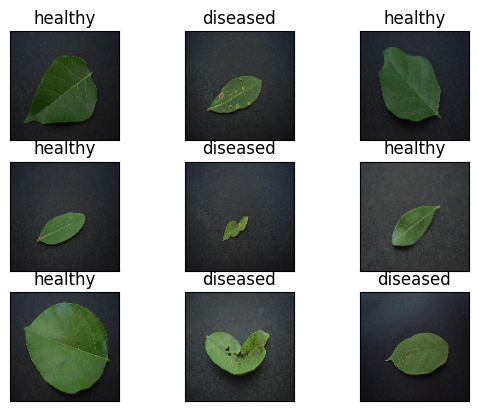

In [15]:
#Realizo el plotteo para algunas imágenes de la validación
import matplotlib.pyplot as plt

for batch,batch_labels in val_data:
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.xticks([]),plt.yticks([])
        plt.title(clases[int(batch_labels[i])])
        plt.imshow(batch[i])
    break

# Modelo from scratch

In [16]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import L2

In [17]:
m_s=keras.Input((128,128,3))
x0=layers.Conv2D(filters=32,kernel_size=3,activation="relu")(m_s)
x0=layers.MaxPooling2D(pool_size=(2,2))(x0)


x0=layers.Conv2D(filters=64,kernel_size=3,activation="relu")(x0)
x0=layers.MaxPooling2D(pool_size=(2,2))(x0)


x0=layers.Conv2D(filters=128,kernel_size=3,activation="relu")(x0)
x0=layers.MaxPooling2D(pool_size=(2,2))(x0)


x0=layers.Conv2D(filters=256,kernel_size=3,activation="relu")(x0)
x0=layers.MaxPooling2D(pool_size=(2,2))(x0)


x0=layers.GlobalAveragePooling2D()(x0) #GlobalAveragePooling --> 256, 1d vector
x0=layers.Dense(50,activation="relu")(x0)
x0=layers.Dropout(0.3)(x0)
m_o=layers.Dense(1,activation="sigmoid")(x0)

modelo_scratch=keras.Model(m_s,m_o)

In [18]:
modelo_scratch.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │          12,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 401,317 (1.53 MB)

 Trainable params: 401,317 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
ES_scratch=EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True #Para que se 'restablezcan' los mejores pesos luego de que el callback para el training
)

In [20]:
#Compile step
from tensorflow.keras.optimizers import Adam

modelo_scratch.compile(
    optimizer=Adam(learning_rate=0.001), #Depende de cómo van los valores en el training, iré cambiando los valores
    loss="binary_crossentropy", #Pues es clasificación binaria
    metrics=["accuracy"]
    )

In [21]:
#Training step
history_scratch=modelo_scratch.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[ES_scratch]
    )

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


136/136 ━━━━━━━━━━━━━━━━━━━━ 481s 3s/step - accuracy: 0.5222 - loss: 0.6922 - val_accuracy: 0.6416 - val_loss: 0.6774
Epoch 2/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 385s 3s/step - accuracy: 0.6129 - loss: 0.6708 - val_accuracy: 0.6150 - val_loss: 0.6391
Epoch 3/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 385s 3s/step - accuracy: 0.6439 - loss: 0.6431 - val_accuracy: 0.6799 - val_loss: 0.6026
Epoch 4/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 454s 3s/step - accuracy: 0.6876 - loss: 0.5861 - val_accuracy: 0.7404 - val_loss: 0.5198
Epoch 5/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 383s 3s/step - accuracy: 0.7716 - loss: 0.5112 - val_accuracy: 0.8009 - val_loss: 0.4432
Epoch 6/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 388s 3s/step - accuracy: 0.7902 - loss: 0.4767 - val_accuracy: 0.8333 - val_loss: 0.4331
Epoch 7/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 393s 3s/step - accuracy: 0.8197 - loss: 0.4190 - val_accuracy: 0.8569 - val_loss: 0.3382
Epoch 8/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 395s 3s/step - accuracy: 0.8590 - loss: 0.3571 - val_accuracy: 0.854

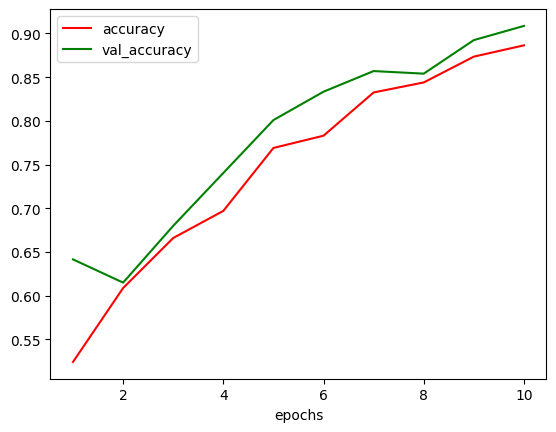

In [22]:
import matplotlib.pyplot as plt
accuracy_sc=history_scratch.history["accuracy"]
val_accuracy_sc=history_scratch.history["val_accuracy"]
epochs=range(1,len(accuracy_sc)+1)

plt.plot(epochs,accuracy_sc,"red",label="accuracy")
plt.plot(epochs,val_accuracy_sc,"green",label="val_accuracy")
plt.xlabel("epochs")
plt.legend()
plt.show()

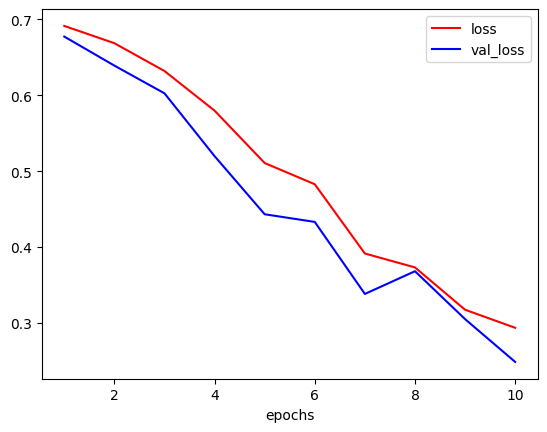

In [23]:
loss_sc=history_scratch.history["loss"]
val_loss_sc=history_scratch.history["val_loss"]
epochs=range(1,len(loss_sc)+1)

plt.plot(epochs,loss_sc,"red",label="loss")
plt.plot(epochs,val_loss_sc,"blue",label="val_loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [24]:
#Predicciones
val_pred_sc=modelo_scratch.predict(val_data)

34/34 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step


In [25]:
val_pred_sc=(val_pred_sc>0.5).astype("int32")

In [26]:
val_pred_n_sc=val_pred_sc.reshape(val_pred_sc.shape[0],)

In [27]:
val_labels_sc=val_data.classes

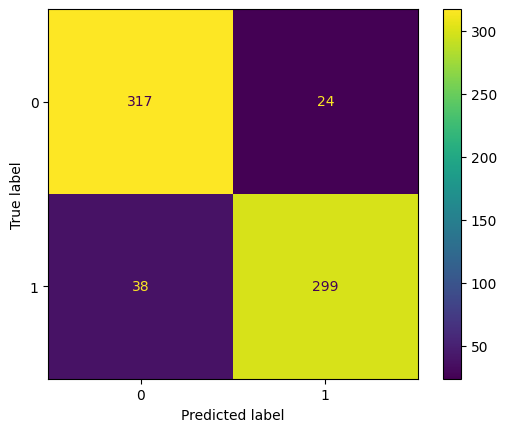

In [28]:
#Matriz de confusión
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score,precision_score
c_m_s=confusion_matrix(val_labels_sc,val_pred_n_sc)
c_m_d_s=ConfusionMatrixDisplay(c_m_s)
c_m_d_s.plot()

In [29]:
#Accuracy
acc_sc=accuracy_score(val_labels_sc,val_pred_n_sc)
print(f"Accuracy: {acc_sc}")

Accuracy: 0.9085545722713865


In [30]:
#Precision score: la clase positiva es el label "diseased"
precision_sc=precision_score(val_labels_sc,val_pred_n_sc)
print(f"Precision: {precision_sc}")

Precision: 0.9256965944272446


-------------------

# Modelo 2: NO Fine-Tuning

In [31]:
#Ya que la data fue cargada correctamente, import el modelo preentrenado VGG16
from tensorflow.keras.applications import vgg16
VGG16=vgg16.VGG16(
    input_shape=(128,128,3),
    include_top=False,
    weights="imagenet"
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [32]:
#Establezco que los pesos del modelo de la base convolucional no sean entrenables
VGG16.trainable=False

In [33]:
VGG16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [34]:
#Añado las capas densamente conectadas
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import L2

x1=VGG16.output
x1=layers.Flatten()(x1) #Capa flatten para que sea un vector 1-d

x1=layers.Dense(1000,activation="relu")(x1) 
x1=layers.BatchNormalization()(x1)
x1=layers.Dropout(0.3)(x1) #30% de dropout

x1=layers.Dense(100,activation="relu")(x1)
x1=layers.BatchNormalization()(x1)
x1=layers.Dropout(0.3)(x1) #30% de dropout

output=layers.Dense(1,activation="sigmoid")(x1) #1 neurona en la capa de salida: pues es binary classification
modelo=keras.Model(VGG16.inputs,output) #Creación del modelo

In [35]:
modelo.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1000)                │       8,193,000 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 23,012,289 (87.78 MB)

 Trainable params: 8,295,401 (31.64 MB)

 Non-trainable params: 14,716,888 (56.14 MB)

In [36]:
#Defino el callback EarlyStopping para frenar el training cuando el modelo empieza a sobreajustarse
from tensorflow.keras.callbacks import EarlyStopping
ES=EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True #Para que se 'restablezcan' los mejores pesos luego de que el callback para el training
)

In [37]:
#Compile step
from tensorflow.keras.optimizers import Adam

modelo.compile(
    optimizer=Adam(learning_rate=0.001), #Depende de cómo van los valores en el training, iré cambiando los valores
    loss="binary_crossentropy", #Pues es clasificación binaria
    metrics=["accuracy"]
    )

In [38]:
#Training step
history=modelo.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[ES]
    )

Epoch 1/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 406s 3s/step - accuracy: 0.6394 - loss: 0.7681 - val_accuracy: 0.5044 - val_loss: 1.4330
Epoch 2/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 374s 3s/step - accuracy: 0.7124 - loss: 0.5752 - val_accuracy: 0.7714 - val_loss: 0.5065
Epoch 3/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.7363 - loss: 0.5420 - val_accuracy: 0.7021 - val_loss: 0.6183
Epoch 4/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 375s 3s/step - accuracy: 0.7398 - loss: 0.5087 - val_accuracy: 0.8068 - val_loss: 0.4155
Epoch 5/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 368s 3s/step - accuracy: 0.7679 - loss: 0.4906 - val_accuracy: 0.8038 - val_loss: 0.4107
Epoch 6/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 378s 3s/step - accuracy: 0.7849 - loss: 0.4628 - val_accuracy: 0.7065 - val_loss: 0.5587
Epoch 7/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 427s 3s/step - accuracy: 0.7860 - loss: 0.4693 - val_accuracy: 0.8230 - val_loss: 0.3854
Epoch 8/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 415s 3s/step - accuracy: 0.7914 - loss: 0.4263 - val_accu

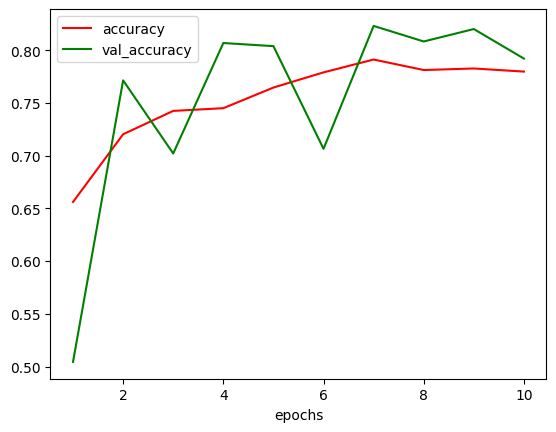

In [39]:
import matplotlib.pyplot as plt
accuracy=history.history["accuracy"]
val_accuracy=history.history["val_accuracy"]
epochs=range(1,len(accuracy)+1)

plt.plot(epochs,accuracy,"red",label="accuracy")
plt.plot(epochs,val_accuracy,"green",label="val_accuracy")
plt.xlabel("epochs")
plt.legend()
plt.show()

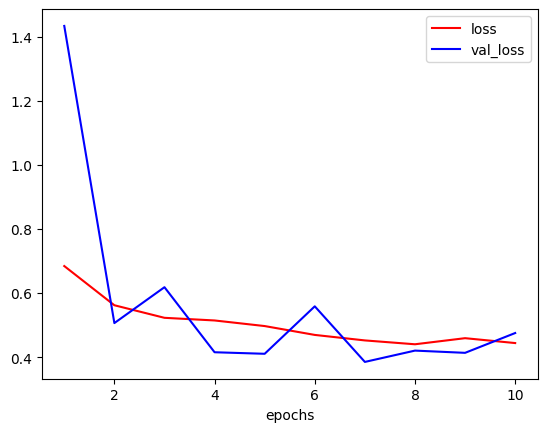

In [40]:
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1,len(accuracy)+1)

plt.plot(epochs,loss,"red",label="loss")
plt.plot(epochs,val_loss,"blue",label="val_loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [41]:
#Predicciones
val_pred=modelo.predict(val_data)

34/34 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step


In [42]:
val_pred_n=(val_pred>0.5).astype("int32")

In [43]:
val_pred_n=val_pred_n.reshape(val_pred_n.shape[0],)

In [44]:
val_labels_=val_data.classes

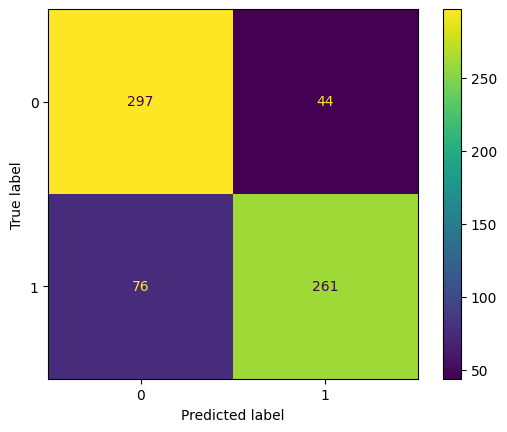

In [45]:
#Matriz de confusión
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score,precision_score
c_m_1=confusion_matrix(val_labels_,val_pred_n)
c_m_d_1=ConfusionMatrixDisplay(c_m_1)
c_m_d_1.plot()

In [46]:
#Accuracy
acc1=accuracy_score(val_labels_,val_pred_n)
print(f"Accuracy: {acc1}")

Accuracy: 0.8230088495575221


In [47]:
#Precision score: la clase positiva es el label "diseased"
precision1=precision_score(val_labels_,val_pred_n)
print(f"Precision: {precision1}")

Precision: 0.8557377049180328


----------

# Modelo 3: Modelo SÍ Fine-Tuning

In [48]:
from tensorflow.keras.applications import vgg16
VGG16_2=vgg16.VGG16(
    input_shape=(128,128,3),
    include_top=False,
    weights="imagenet"
)

In [49]:
VGG16_2.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
VGG16_2.trainable=True

In [51]:
for layer in VGG16_2.layers[:-2]: #Última capa, ya que la de max pooling no se entrena
    layer.trainable=False

In [52]:
VGG16_2.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 2,359,808 (9.00 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [53]:
x2=VGG16_2.output
x2=layers.Flatten()(x2) #Capa flatten para que sea un vector 1-d

x2=layers.Dense(1000,activation="relu")(x2) 
x2=layers.BatchNormalization()(x2)
x2=layers.Dropout(0.3)(x2) #30% de dropout

x2=layers.Dense(100,activation="relu")(x2)
x2=layers.BatchNormalization()(x2)
x2=layers.Dropout(0.3)(x2) #30% de dropout

output2=layers.Dense(1,activation="sigmoid")(x2) #1 neurona en la capa de salida: pues es binary classification
modelo2=keras.Model(VGG16_2.inputs,output2) #Creación del modelo

In [54]:
#Defino el callback EarlyStopping para frenar el training cuando el modelo empieza a sobreajustarse
from tensorflow.keras.callbacks import EarlyStopping
ES2=EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True #Para que se 'restablezcan' los mejores pesos luego de que el callback para el training
)

In [55]:
#Compile step
from tensorflow.keras.optimizers import Adam

modelo2.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss="binary_crossentropy", #Pues es clasificación binaria
    metrics=["accuracy"]
    )

In [56]:
#Training step
history2=modelo2.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[ES2]
    )

Epoch 1/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 371s 3s/step - accuracy: 0.6267 - loss: 0.7882 - val_accuracy: 0.7242 - val_loss: 0.8791
Epoch 2/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 368s 3s/step - accuracy: 0.7188 - loss: 0.5787 - val_accuracy: 0.7670 - val_loss: 0.4795
Epoch 3/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 363s 3s/step - accuracy: 0.7491 - loss: 0.5079 - val_accuracy: 0.7832 - val_loss: 0.4300
Epoch 4/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 362s 3s/step - accuracy: 0.7821 - loss: 0.4820 - val_accuracy: 0.7832 - val_loss: 0.5158
Epoch 5/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 370s 3s/step - accuracy: 0.7884 - loss: 0.4572 - val_accuracy: 0.7404 - val_loss: 0.5325
Epoch 6/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 385s 3s/step - accuracy: 0.7679 - loss: 0.4672 - val_accuracy: 0.7979 - val_loss: 0.4276
Epoch 7/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 364s 3s/step - accuracy: 0.7849 - loss: 0.4685 - val_accuracy: 0.7876 - val_loss: 0.4448
Epoch 8/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 371s 3s/step - accuracy: 0.8080 - loss: 0.4165 - val_accu

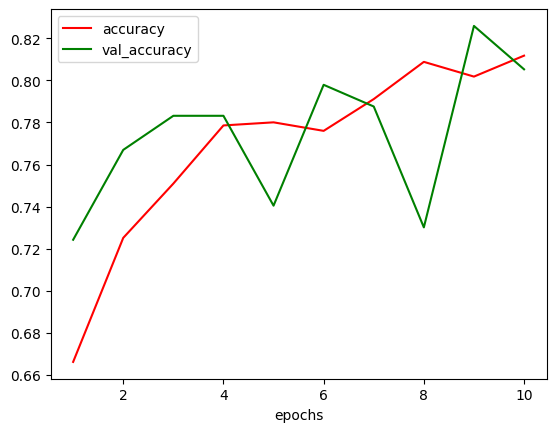

In [57]:
accuracy2=history2.history["accuracy"]
val_accuracy2=history2.history["val_accuracy"]
epochs=range(1,len(accuracy2)+1)

plt.plot(epochs,accuracy2,"red",label="accuracy")
plt.plot(epochs,val_accuracy2,"green",label="val_accuracy")
plt.xlabel("epochs")
plt.legend()
plt.show()

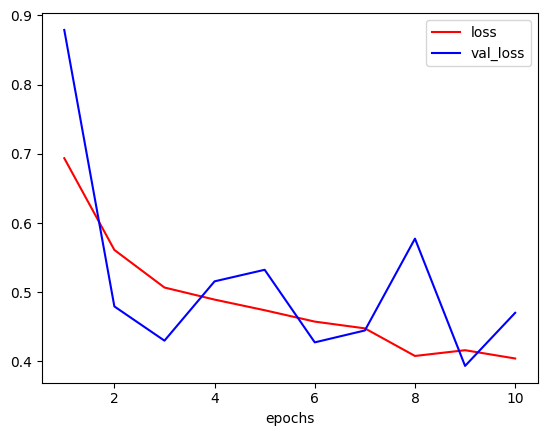

In [58]:
loss2=history2.history["loss"]
val_loss2=history2.history["val_loss"]
epochs=range(1,len(loss2)+1)

plt.plot(epochs,loss2,"red",label="loss")
plt.plot(epochs,val_loss2,"blue",label="val_loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [59]:
#Predicciones
val_pred2=modelo2.predict(val_data)

34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step


In [60]:
val_pred2_n=(val_pred2>0.5).astype("int32")

In [61]:
val_pred2_n=val_pred2_n.reshape(val_pred2_n.shape[0],)

In [62]:
val_labels=val_data.classes

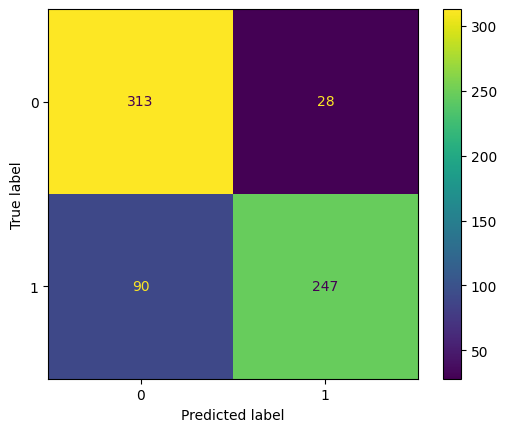

In [63]:
#Matriz de confusión
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score,precision_score
c_m=confusion_matrix(val_labels,val_pred2_n)
c_m_d=ConfusionMatrixDisplay(c_m)
c_m_d.plot()

In [64]:
#Accuracy
acc=accuracy_score(val_labels,val_pred2_n)
print(f"Accuracy: {acc}")

Accuracy: 0.8259587020648967


In [65]:
#Precision score: la clase positiva es el label "diseased"
precision=precision_score(val_labels,val_pred2_n)
print(f"Precision: {precision}")

Precision: 0.8981818181818182


---------

In [66]:
#Obtengo la data de test
import cv2
img_size= 128

#Cargar y resize a las imágenes
def CargarTest(image_path):
    imagen = cv2.imread(image_path)
    imagen = cv2.resize(imagen, (img_size,img_size))
    imagen = imagen / 255.0  #Normalizando la data
    return imagen

In [67]:
#Preprocesamiento para todas las imágenes
imagenes = []

for i,fila in test_df.iterrows():
    nombre_img=fila["Images"]
    imgs=os.path.join(path_base_img,nombre_img)
    imagenes.append(CargarTest(imgs))

In [68]:
#Convierto a un array
import numpy as np
x_test=np.array(imagenes)

In [69]:
#Predicción
pred_final=modelo2.predict(x_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step


In [70]:
pred_final_labels=(pred_final>0.5).astype("int32")

In [71]:
pred_final_labels=pred_final_labels.reshape(pred_final_labels.shape[0],)

In [72]:
#Creo el dataframe
submission_df = pd.DataFrame({
    'Images': test_df['Images'],
    'Labels': pred_final_labels
})

In [73]:
submission_df.to_csv('submission.csv', index=False)
print('Submission file was created.')

Submission file was created.
